In [4]:
!pip install freesound-api



In [13]:
import os
import requests
from freesound import FreesoundClient
from tqdm.notebook import tqdm
import time

# ==========================================
# 1. CONFIGURATION
# ==========================================
API_KEY = "SgeY5RITw5KXpWvom3XgUzOV32uWoU6hs49Dt8IM" 
client = FreesoundClient()
client.set_token(API_KEY)

DATASET_DIR = "submarine_dataset_strict"
TARGET_SAMPLES = 50  # Goal: 50 files per search term

# STRICT RULES
FORBIDDEN_WORDS = ["space", "sci-fi", "alien", "bat", "insect", "bird", "synth", "music", "game", "cartoon"]
REQUIRED_TAGS_SUB = ["underwater", "water", "sea", "ocean"] # Submarines MUST be underwater

CLASSES = {
    "SUBMARINE": [
        "submarine sonar", 
        "active sonar ping", 
        "submarine interior",
        "torpedo launch underwater", 
        "hydrophone submarine"
    ],
    "NO_SUBMARINE": [
        "underwater ambience", 
        "whale song", 
        "scuba breathing", 
        "boat propeller underwater",
        "underwater volcano",
        "shrimp snapping"
    ]
}

# ==========================================
# 2. STRICT DOWNLOADER
# ==========================================
if not os.path.exists(DATASET_DIR):
    os.makedirs(DATASET_DIR)

print(f"--- Starting Strict Download (Target: {TARGET_SAMPLES} per query) ---")

for label, queries in CLASSES.items():
    save_dir = os.path.join(DATASET_DIR, label)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for query in queries:
        print(f"\nProcessing: '{query}' for class {label}...")
        count = 0
        page = 1
        
        while count < TARGET_SAMPLES:
            try:
                results = client.text_search(
                    query=query, 
                    fields="id,name,previews,duration,tags,description", 
                    sort="rating_desc", 
                    page_size=30,
                    page=page
                )
                
                # Stop if no more pages
                if not results: break
                
                for sound in results:
                    if count >= TARGET_SAMPLES: break
                    
                    # --- STRICT FILTERS ---
                    
                    # 1. Duration Check (1s to 30s)
                    if sound.duration < 1.0 or sound.duration > 30.0:
                        continue
                        
                    # 2. Ban List Check (No Bats/Space!)
                    name_lower = sound.name.lower()
                    desc_lower = sound.description.lower() if sound.description else ""
                    if any(bad in name_lower for bad in FORBIDDEN_WORDS) or \
                       any(bad in desc_lower for bad in FORBIDDEN_WORDS):
                        continue
                        
                    # 3. Context Check (Only for Submarines)
                    # If looking for subs, ensure it's actually underwater, not a movie sound effect
                    if label == "SUBMARINE":
                        # Check if any required tag exists in the sound's tags
                        if not any(tag in sound.tags for tag in REQUIRED_TAGS_SUB):
                            # Allow if "underwater" is in the name instead
                            if "underwater" not in name_lower and "sonar" not in name_lower:
                                continue

                    # --- DOWNLOAD ---
                    safe_name = "".join([c for c in sound.name if c.isalnum()]).rstrip()
                    filename = f"{sound.id}_{safe_name}.mp3"
                    filepath = os.path.join(save_dir, filename)
                    
                    if not os.path.exists(filepath):
                        try:
                            preview_url = sound.previews.preview_hq_mp3
                            r = requests.get(preview_url, timeout=10)
                            with open(filepath, 'wb') as f:
                                f.write(r.content)
                            count += 1
                            print(f"[{count}/{TARGET_SAMPLES}] Downloaded: {sound.name[:30]}...")
                        except:
                            print("  > Error downloading file, skipping.")
                    else:
                        count += 1 # Count existing files
                
                page += 1
                # Polite delay for API
                time.sleep(1.0)
                
            except Exception as e:
                print(f"Search Error or End of Results: {e}")
                break

print("\nDONE! You now have a strict, high-quality dataset.")

--- Strict Download (Target: 50) ---

Processing: submarine sonar → SUBMARINE
Search ended: <FreesoundException: code=404, detail="Not Found">

Processing: active sonar ping → SUBMARINE
Search ended: <FreesoundException: code=404, detail="Not Found">

Processing: submarine interior → SUBMARINE
Search ended: <FreesoundException: code=404, detail="Not Found">

Processing: torpedo launch underwater → SUBMARINE
Search ended: <FreesoundException: code=404, detail="Not Found">

Processing: hydrophone submarine → SUBMARINE
Search ended: <FreesoundException: code=404, detail="Not Found">

Processing: underwater ambience → NO_SUBMARINE
Search ended: <FreesoundException: code=404, detail="Not Found">

Processing: whale song → NO_SUBMARINE
Search ended: <FreesoundException: code=404, detail="Not Found">

Processing: scuba breathing → NO_SUBMARINE
Search ended: <FreesoundException: code=404, detail="Not Found">

Processing: boat propeller underwater → NO_SUBMARINE
Search ended: <FreesoundException

In [14]:
import os
import glob

DATA_DIR = "submarine_dataset_strict"

# 1. Define words that indicate "Fake" or "Bad" data
BAD_WORDS = [
    "PING PONG",   # Musical notes
    "MONSTER",     # Fantasy sounds
    "Roar",        # Fantasy sounds
    "Sewer",       # Wrong water type
    "pads",        # Synthesizer music
    "Alien",       # Sci-fi
    "Meteor",      # Sci-fi
    "Stream",      # River sounds (not ocean)
    "handspinn"    # Fidget spinner?
]

print("--- Cleaning Dataset ---")
deleted_count = 0

# Scan both folders
for class_name in ["SUBMARINE", "NO_SUBMARINE"]:
    folder_path = os.path.join(DATA_DIR, class_name)
    files = glob.glob(f"{folder_path}/*")
    
    for file_path in files:
        file_name = os.path.basename(file_path)
        
        # Check if any bad word is in the filename
        if any(bad in file_name for bad in BAD_WORDS):
            try:
                os.remove(file_path)
                print(f"Deleted Bad File: {file_name}")
                deleted_count += 1
            except Exception as e:
                print(f"Could not delete {file_name}: {e}")

# 2. Fix the Duplicate (Sub Ambience appeared in both folders)
# We remove it from NO_SUBMARINE to keep the classes distinct
duplicate = os.path.join(DATA_DIR, "NO_SUBMARINE", "Sub Int or Ext Ambience.wav")
if os.path.exists(duplicate):
    os.remove(duplicate)
    print("Deleted Duplicate: Sub Int or Ext Ambience.wav from NO_SUBMARINE")
    deleted_count += 1

print(f"\nTotal Cleaned: {deleted_count} files.")
print("Your data is now ready for training!")

--- Cleaning Dataset ---
Deleted Bad File: 246156_15capadswav.mp3
Deleted Bad File: 550257_MONSTERSOUNDwav.mp3
Deleted Bad File: 493079_13StreamVastDitchSpaciousFlatBrightTricklingEerieFlowingUnderwaterDiveDeep2Freebiewav.mp3
Deleted Bad File: 514422_RuizYlona20192020handspinnerwav.mp3
Deleted Bad File: 493072_07StreamCalmStreakTricklingBubblesFlowingUnderwaterDiveDeep2Freebiewav.mp3
Deleted Bad File: 493071_08StreamDenseLiquidTricklingFlowingUnderwaterDiveDeep2Freebiewav.mp3
Deleted Bad File: 240311_NemeanRoarwav.mp3
Deleted Bad File: 493076_09StreamDirtySewerDarkTricklingBurblingFlowingUnderwaterDiveDeep2Freebiewav.mp3
Deleted Bad File: 493077_12StreamMuddyCurrentDarkTricklingDripsFlowingUnderwaterDiveDeep2Freebiewav.mp3
Deleted Bad File: 493078_11StreamKnifeCurrentDetailSharpBrightTricklingDripsFlowingUnderwaterDiveDeep2Freebiewav.mp3
Deleted Bad File: 493075_10StreamHiddenCanalSpaciousTricklingDripsNoisesFlowingUnderwaterDiveDeep2Freebiewav.mp3
Deleted Bad File: 514420_RuizYlona201

Loading Cleaned Data...
Total Clean Files: 84
Starting Training on cuda...
Epoch 5 | Loss: 0.2502 | Val Acc: 82.35%
Epoch 10 | Loss: 0.3096 | Val Acc: 82.35%
Epoch 15 | Loss: 0.2300 | Val Acc: 82.35%
Epoch 20 | Loss: 0.1809 | Val Acc: 76.47%
Epoch 25 | Loss: 0.0869 | Val Acc: 88.24%

--- Final Evaluation ---


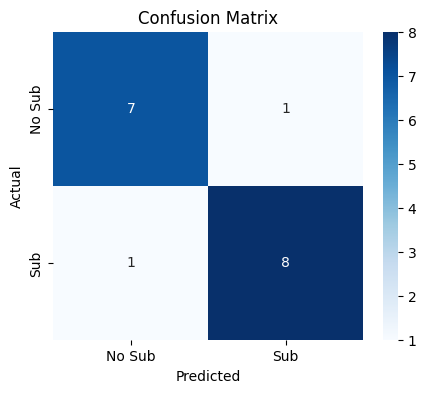

              precision    recall  f1-score   support

      No Sub       0.88      0.88      0.88         8
   Submarine       0.89      0.89      0.89         9

    accuracy                           0.88        17
   macro avg       0.88      0.88      0.88        17
weighted avg       0.88      0.88      0.88        17

Model saved as 'submarine_resnet_clean.pth'


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import librosa
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# ================= CONFIG =================
CONFIG = {
    'DEVICE': 'cuda' if torch.cuda.is_available() else 'cpu',
    'BATCH_SIZE': 8,       
    'EPOCHS': 25,          # Increased slightly since data is harder now
    'LR': 0.0001,
    'DATA_DIR': "submarine_dataset_strict"
}

# ================= AUGMENTED DATASET =================
class AugmentedSonarDataset(Dataset):
    def __init__(self, file_paths, labels, is_train=True):
        self.files = file_paths
        self.labels = labels
        self.is_train = is_train

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        try:
            # Load & Pad
            y, sr = librosa.load(self.files[idx], sr=16000)
            
            # --- AUGMENTATION (Train Only) ---
            if self.is_train:
                # 1. Noise Injection
                noise_amp = 0.005 * np.random.uniform() * np.amax(y)
                y = y + noise_amp * np.random.normal(size=y.shape[0])
                
                # 2. Time Shift (Critical for pings)
                shift = np.random.randint(len(y) * 0.5)
                y = np.roll(y, shift)

            # Pad to 4s
            max_len = 16000 * 4
            if len(y) < max_len: y = np.pad(y, (0, max_len - len(y)))
            else: y = y[:max_len]

            # Spectrogram
            spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            spec_db = librosa.power_to_db(spec, ref=np.max)
            
            # 3. Freq Masking
            if self.is_train and np.random.random() > 0.5:
                f = np.random.randint(0, 20)
                s = np.random.randint(0, 128 - f)
                spec_db[s:s+f, :] = -80

            # Normalize
            spec_db = (spec_db - spec_db.min()) / (spec_db.max() - spec_db.min() + 1e-6)
            
            return torch.tensor(spec_db, dtype=torch.float32).unsqueeze(0), torch.tensor(self.labels[idx], dtype=torch.float32)
        except:
            return torch.zeros((1, 128, 126)), torch.tensor(0.0)

# ================= PREPARE DATA =================
print("Loading Cleaned Data...")
all_files = []
all_labels = []

# Label 1 = Submarine, 0 = Noise
for f in glob.glob(f"{CONFIG['DATA_DIR']}/SUBMARINE/*"):
    all_files.append(f); all_labels.append(1)
for f in glob.glob(f"{CONFIG['DATA_DIR']}/NO_SUBMARINE/*"):
    all_files.append(f); all_labels.append(0)

print(f"Total Clean Files: {len(all_files)}")

# Stratified Split
train_files, test_files, train_y, test_y = train_test_split(
    all_files, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

train_ds = AugmentedSonarDataset(train_files, train_y, is_train=True)
test_ds = AugmentedSonarDataset(test_files, test_y, is_train=False)

train_loader = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True)
test_loader = DataLoader(test_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False)

# ================= MODEL =================
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(CONFIG['DEVICE'])

optimizer = optim.Adam(model.parameters(), lr=CONFIG['LR'])
criterion = nn.BCEWithLogitsLoss()

# ================= TRAIN =================
print(f"Starting Training on {CONFIG['DEVICE']}...")
history = {'loss': [], 'acc': []}

for epoch in range(CONFIG['EPOCHS']):
    model.train()
    total_loss = 0
    
    for X, y in train_loader:
        X, y = X.to(CONFIG['DEVICE']), y.to(CONFIG['DEVICE']).unsqueeze(1)
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(CONFIG['DEVICE']), y.to(CONFIG['DEVICE']).unsqueeze(1)
            preds = (torch.sigmoid(model(X)) > 0.5).float()
            correct += (preds == y).sum().item()
            total += y.size(0)
            
    acc = correct/total
    history['loss'].append(total_loss/len(train_loader))
    history['acc'].append(acc)
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f} | Val Acc: {acc:.2%}")

# ================= FINAL REPORT =================
print("\n--- Final Evaluation ---")
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(CONFIG['DEVICE'])
        preds = (torch.sigmoid(model(X)) > 0.5).float().cpu().numpy()
        y_true.extend(y.numpy())
        y_pred.extend(preds)

# 1. Confusion Matrix Plot
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Sub', 'Sub'], yticklabels=['No Sub', 'Sub'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 2. Classification Report
print(classification_report(y_true, y_pred, target_names=['No Sub', 'Submarine']))

# 3. Save Model
torch.save(model.state_dict(), 'submarine_resnet_clean.pth')
print("Model saved as 'submarine_resnet_clean.pth'")

--- Extracting 4 Features for ML Model ---
Processing NO_SUBMARINE (39 files)...
Processing SUBMARINE (45 files)...

Total Samples Extracted: 84
Training Random Forest on 67 samples...

=== ML Model Results (Random Forest) ===
Accuracy: 70.59%

Classification Report:
              precision    recall  f1-score   support

      No Sub       0.71      0.62      0.67         8
   Submarine       0.70      0.78      0.74         9

    accuracy                           0.71        17
   macro avg       0.71      0.70      0.70        17
weighted avg       0.71      0.71      0.70        17



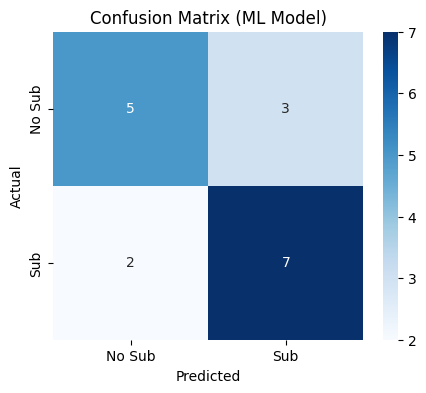


--- What did the AI look at? ---
1. MFCCs (Texture):      0.8218
2. Centroid (Bright):    0.0613
3. ZCR (Noisiness):      0.0656
4. Rolloff (Shape):      0.0512


In [18]:
import os
import glob
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# ================= 1. CONFIGURATION =================
DATASET_DIR = "submarine_dataset_strict" 

# ================= 2. FEATURE EXTRACTOR (4 Features) =================
def extract_features(file_path):
    try:
        # Load audio (resample to 16k to save time)
        y, sr = librosa.load(file_path, sr=16000)
        
        # Skip if file is too short (less than 0.1s)
        if len(y) < 1600: return None

        # --- FEATURE 1: MFCC (Texture) ---
        # We take the mean of 13 coefficients
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
        
        # --- FEATURE 2: Spectral Centroid (Brightness) ---
        # Distinguishes "dark" sounds (humming) from "bright" sounds (clicks)
        centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T, axis=0)
        
        # --- FEATURE 3: Zero Crossing Rate (Noisiness) ---
        # Distinguishes noise (high ZCR) from tonal sounds (low ZCR)
        zcr = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0)
        
        # --- FEATURE 4: Spectral Rolloff (Shape) ---
        # The frequency below which 85% of the magnitude distribution lies
        rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr).T, axis=0)
        
        # Combine all into one flat array
        # MFCC is an array of 13 numbers. The others are single numbers.
        # Total features = 13 + 1 + 1 + 1 = 16 inputs per file
        return np.hstack([mfcc, centroid, zcr, rolloff])
        
    except Exception as e:
        return None

# ================= 3. BUILD DATASET =================
print("--- Extracting 4 Features for ML Model ---")
X_data = []
y_data = []

# Map: No Sub = 0, Sub = 1
labels_map = {"NO_SUBMARINE": 0, "SUBMARINE": 1}

for label_name, label_idx in labels_map.items():
    folder = os.path.join(DATASET_DIR, label_name)
    files = glob.glob(f"{folder}/*")
    
    print(f"Processing {label_name} ({len(files)} files)...")
    
    for file in files:
        features = extract_features(file)
        if features is not None:
            X_data.append(features)
            y_data.append(label_idx)

X = np.array(X_data)
y = np.array(y_data)

print(f"\nTotal Samples Extracted: {len(X)}")

# ================= 4. TRAIN MODEL =================
if len(X) < 10:
    print("⚠️ ERROR: Not enough data! Check your folder.")
else:
    # Split: 80% Train, 20% Test (Stratified)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"Training Random Forest on {len(X_train)} samples...")
    
    # Initialize Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # ================= 5. EVALUATE =================
    y_pred = rf_model.predict(X_test)
    
    print("\n=== ML Model Results (Random Forest) ===")
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2%}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["No Sub", "Submarine"]))
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Sub', 'Sub'], yticklabels=['No Sub', 'Sub'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (ML Model)')
    plt.show()

    # ================= 6. FEATURE IMPORTANCE =================
    # See which feature mattered the most!
    importances = rf_model.feature_importances_
    # We aggregate the 13 MFCCs into one "MFCC" score for visualization
    mfcc_imp = np.sum(importances[:13])
    centroid_imp = importances[13]
    zcr_imp = importances[14]
    rolloff_imp = importances[15]
    
    print("\n--- What did the AI look at? ---")
    print(f"1. MFCCs (Texture):      {mfcc_imp:.4f}")
    print(f"2. Centroid (Bright):    {centroid_imp:.4f}")
    print(f"3. ZCR (Noisiness):      {zcr_imp:.4f}")
    print(f"4. Rolloff (Shape):      {rolloff_imp:.4f}")

In [19]:
import joblib

# 1. Save the Model to a file
model_filename = "submarine_rf_model.pkl"
joblib.dump(rf_model, model_filename)

print(f"✅ Model saved as '{model_filename}'")

# --- OPTIONAL: How to Download it (if using Kaggle/Colab) ---
try:
    from google.colab import files
    files.download(model_filename)
    print("Download started...")
except:
    print(f"File is saved locally. Look for {model_filename} in your file explorer.")

✅ Model saved as 'submarine_rf_model.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started...
